# LCLS usage statistics

LCLS makes available a lot of data and statistics on performed experiments and data management, see  https://pswww.slac.stanford.edu/apps/portal/statistics. This data can be downloaded into JSON format (even if it is not really JSON compliant, so some mangling is needed). A lot of interesting data can be retrieved from it.

Let's start with the usual includes

In [182]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import pandas as pd
import json

You should download the json file using a web browser (login is needed), then run this command (replace `lcls_statistics.json` with the actual file name)

In [210]:
!/usr/bin/tr '\n' '\t' < lcls_statistics.json  | sed 's:\t: :g' | sed 's,:{,":{,g' | sed 's,: ,":,g' | sed 's: ::g' | sed 's:,:,":g' | sed 's:{:{":g' | sed 's:"{":{":g' | sed 's:,:,\n:g'  > lcls_statistics_norm.json


Now, let's see...

In [212]:
fname = "lcls_statistics_norm.json"
j = json.load(open(fname))
j.keys()

dict_keys(['total', 'filesystem', 'experiments', 'instruments', 'updated', 'status'])

In [10]:
instruments = [x['name'] for x in j['instruments']]
instruments

['AMO', 'CXI', 'DIA', 'MEC', 'MFX', 'MOB', 'SXR', 'XCS', 'XPP']

Let's see data produced overall by each instrument, how much is on disk, and some statistics about filesystems:

<IPython.core.display.Javascript object>


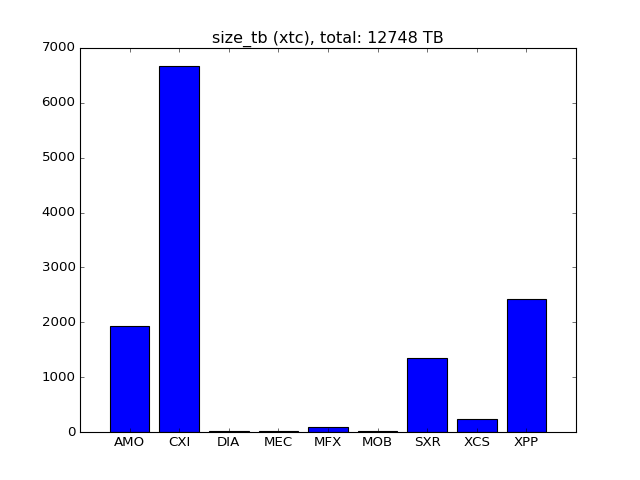

<IPython.core.display.Javascript object>


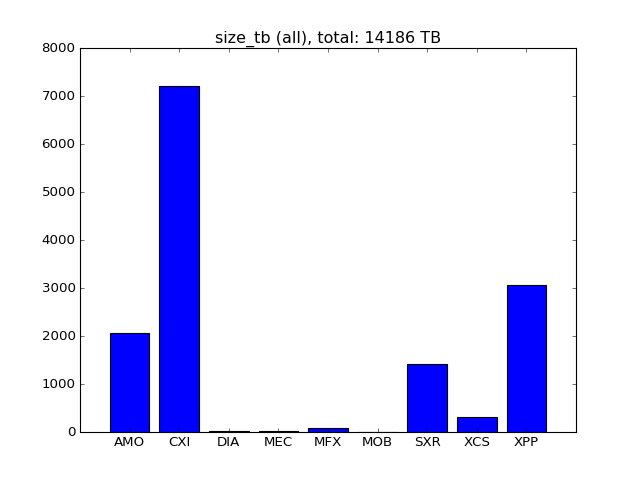

<IPython.core.display.Javascript object>


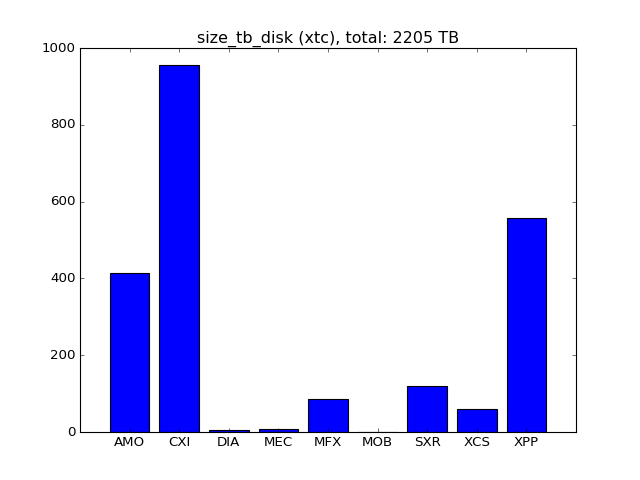

<IPython.core.display.Javascript object>


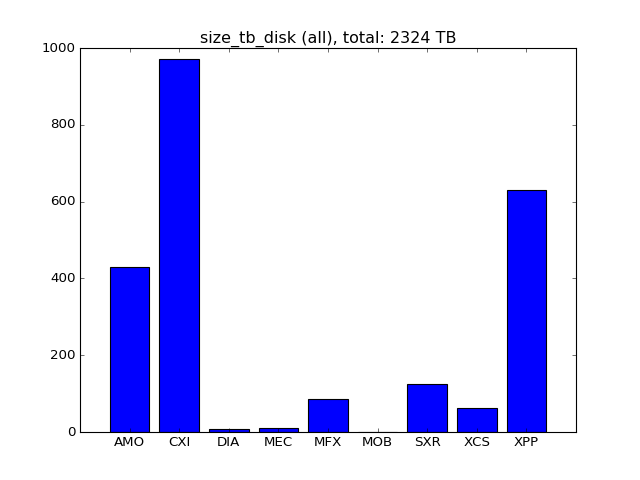

<IPython.core.display.Javascript object>


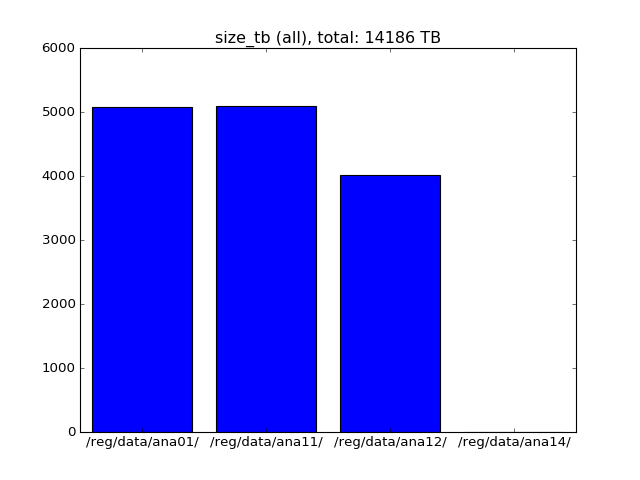

<IPython.core.display.Javascript object>


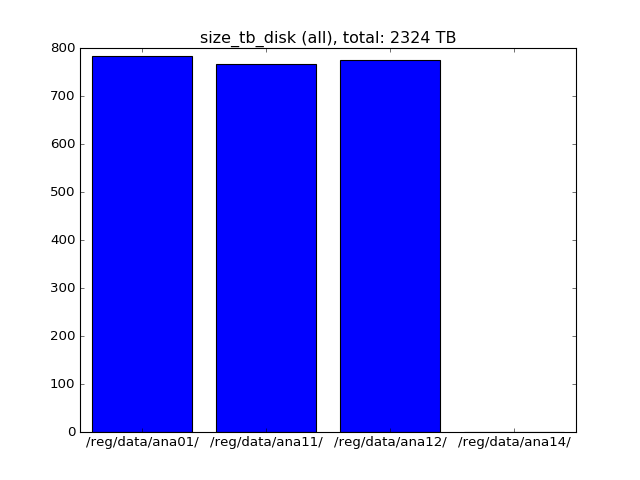

In [213]:
def plot_instr_stats(istats, sname, mode="all"):
    x = []
    y = []
    total = 0
    for i in istats:
        x.append(i['name'])
        if mode == "all":
            n = i[sname]['xtc'] + i[sname]['hdf5']
        elif mode == "hdf5":
            n = i[sname]['hdf5']
        elif mode == "xtc":
            n = i[sname]['xtc']
        y.append(n)          
        total += n
    plt.figure()
    plt.bar(range(len(y)), y, align='center')
    plt.title("%s (%s), total: %.0f TB" % (sname, mode, total))
    plt.xticks(range(len(x)), x)
    
plot_instr_stats(j['instruments'], 'size_tb', 'xtc')
plot_instr_stats(j['instruments'], 'size_tb', 'all')

plot_instr_stats(j['instruments'], 'size_tb_disk', 'xtc')
plot_instr_stats(j['instruments'], 'size_tb_disk', 'all')


plot_instr_stats(j['filesystem'], 'size_tb', 'all')
plot_instr_stats(j['filesystem'], 'size_tb_disk', 'all')


## Experiments statistics

In order to get some more statistics about experiments, let's get the usual `Pandas DataFrame`:

In [215]:
df = pd.DataFrame(data=j['experiments'])
df = df.set_index(pd.to_datetime(df['first_run_begin'])).sort_index()
for i in ["files", "files_disk", "size_tb_disk", "size_tb"]:
    df[i + "_xtc"] = df[i].apply(lambda x: x['xtc'])
    df[i + "_hdf5"] = df[i].apply(lambda x: x['hdf5'])
    df.drop(i, inplace=True, axis=1)

df.head()

,exper_id,exper_name,first_run_begin,instr_name,last_run_begin,runs,files_xtc,files_hdf5,files_disk_xtc,files_disk_hdf5,size_tb_disk_xtc,size_tb_disk_hdf5,size_tb_xtc,size_tb_hdf5
first_run_begin,,,,,,,,,,,,,,
2009-10-01,5,amo01809,2009-10-01,AMO,2009-10-06,432,716,201,130,0,0.8,0.0,3.5,1.1
2009-10-08,7,amo02109,2009-10-08,AMO,2009-10-13,520,526,257,0,0,0.0,0.0,1.6,0.7
2009-10-13,8,amo01509,2009-10-13,AMO,2009-10-20,352,373,163,4,0,0.1,0.0,1.9,0.8
2009-10-20,9,amo02709,2009-10-20,AMO,2009-10-27,824,836,406,0,0,0.0,0.0,1.9,0.7
2009-10-28,6,amo01709,2009-10-28,AMO,2009-11-04,314,318,155,16,0,0.0,0.0,1.7,0.7


<IPython.core.display.Javascript object>


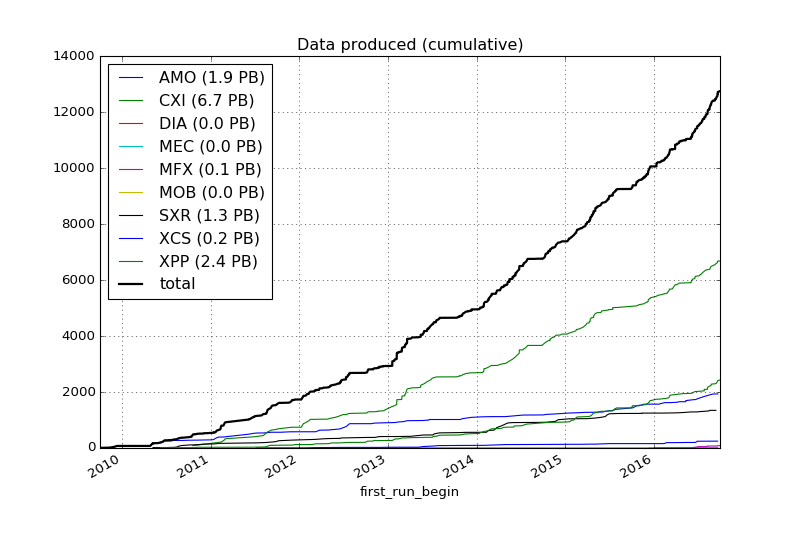

In [216]:
plt.figure(figsize=(10, 7))
for i in instruments:
    d = df[df["instr_name"] == i].size_tb_xtc
    d.cumsum().plot(label="%s (%.1f PB)" % (i, d.sum() / 1000))

df.size_tb_xtc.cumsum().plot(label='total', linewidth=2, color='k')
plt.title("Data produced (cumulative)")
plt.grid()
plt.legend(loc="best")
    

<IPython.core.display.Javascript object>


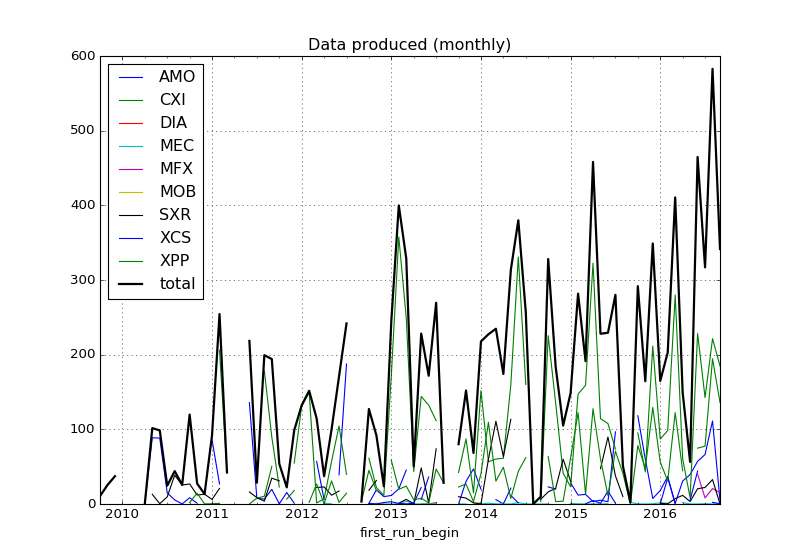

<IPython.core.display.Javascript object>


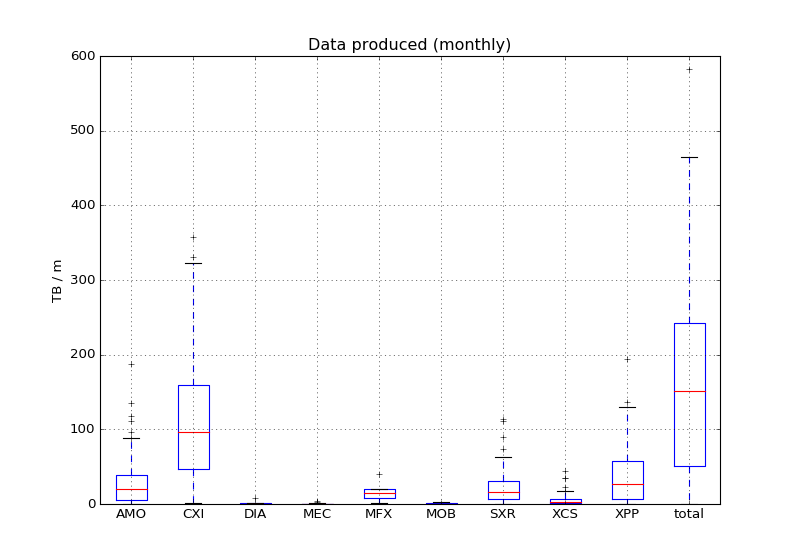

In [218]:
df_m = pd.DataFrame()
plt.figure(figsize=(10, 7))
for i in instruments:
    d = df[df["instr_name"] == i].size_tb_xtc.resample('M').sum()
    df_m[i] = d
    d.plot(label="%s" % (i))

df.size_tb_xtc.resample('M').sum().plot(label='total', linewidth=2, color='k')
df_m["total"] = df.size_tb_xtc.resample('M').sum()
plt.title("Data produced (monthly)")
plt.grid()
plt.legend(loc="best")
#print(df_m)

df_m.plot.box(figsize=(10, 7))
plt.grid()
plt.title("Data produced (monthly)")
plt.ylabel("TB / m")

We can also see year by year, broken down by instrument:

<IPython.core.display.Javascript object>


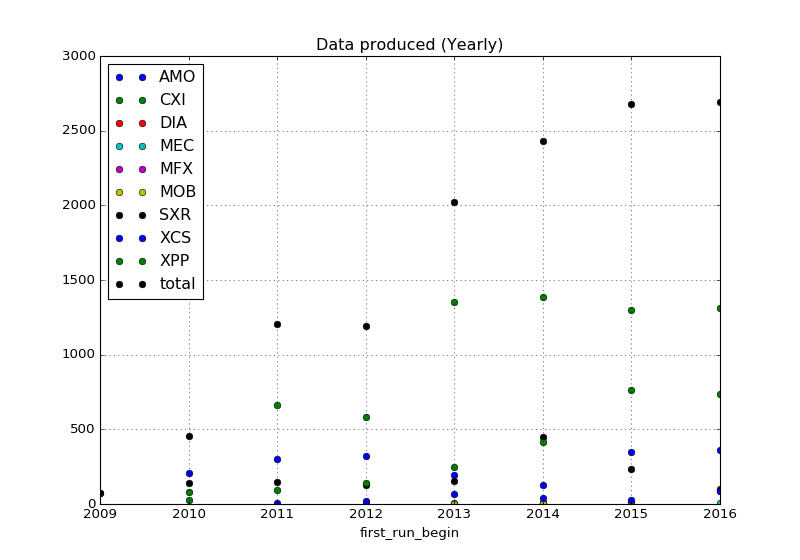

<IPython.core.display.Javascript object>


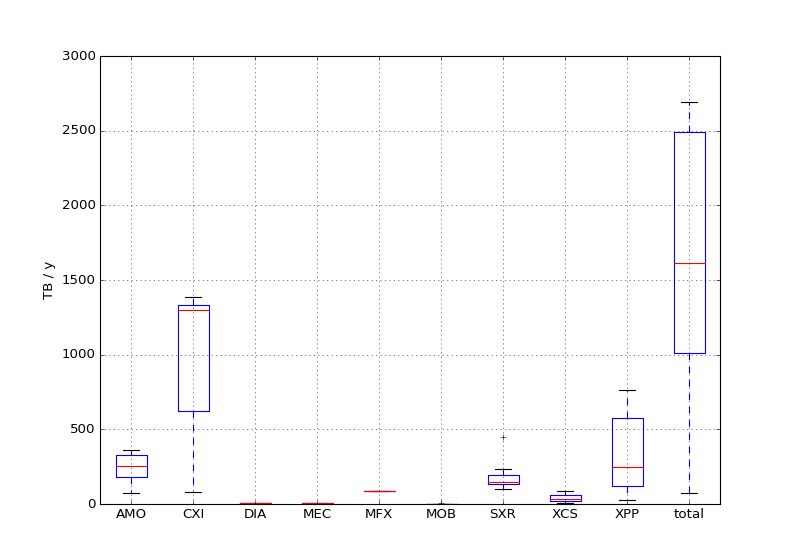

                   AMO     CXI  DIA  MEC   MFX  MOB    SXR   XCS    XPP  \
first_run_begin                                                           
2009-12-31        73.2     NaN  NaN  NaN   NaN  NaN    NaN   NaN    NaN   
2010-12-31       207.2    82.4  NaN  NaN   NaN  NaN  138.8   NaN   26.6   
2011-12-31       298.8   660.1  NaN  NaN   NaN  NaN  145.8   4.9   94.5   
2012-12-31       319.0   585.3  NaN  2.5   NaN  1.5  124.1  18.6  143.4   
2013-12-31       196.7  1354.6  2.2  4.5   NaN  2.1  150.8  67.3  244.7   
2014-12-31       124.7  1386.2  7.5  3.4   NaN  6.3  451.3  37.8  413.8   
2015-12-31       346.8  1297.0  NaN  4.0   NaN  0.4  235.1  28.0  764.1   
2016-12-31       364.9  1311.4  NaN  5.2  85.1  NaN   98.6  87.7  736.9   

                  total  
first_run_begin          
2009-12-31         73.2  
2010-12-31        455.0  
2011-12-31       1204.1  
2012-12-31       1194.4  
2013-12-31       2022.9  
2014-12-31       2431.0  
2015-12-31       2675.4  
2016-12-31     

In [219]:
df_m = pd.DataFrame()
plt.figure(figsize=(10, 7))
for i in instruments:
    d = df[df["instr_name"] == i].size_tb_xtc.resample('A').sum()
    df_m[i] = d
    d.plot(label="%s" % (i), style="o")

df.size_tb_xtc.resample('A').sum().plot(label='total', style="ko", )
df_m["total"] = df.size_tb_xtc.resample('A').sum()
plt.title("Data produced (Yearly)")
plt.grid()
plt.legend(loc="best")

df_m.plot.box(figsize=(10, 7))
plt.grid()
plt.ylabel("TB / y")

print(df_m)

## Soft X ray (SXR) statistics

It can be seen that an experiment at SXR on average produces 15 TB, with a maximum of 100 TB / experiment. Yearly production is usually ~100 TB/y, with peaks of 450 TB / y

In [175]:
iname = "SXR"
#pd.plot_params.use('x_compat', False)

df_s = df[df.instr_name == iname]

df_s.size_tb_xtc.describe()

count     90.000000
mean      14.938889
std       19.541185
min        0.000000
25%        2.300000
50%        7.550000
75%       21.825000
max      100.400000
Name: size_tb_xtc, dtype: float64

Some more data confirming this:

<IPython.core.display.Javascript object>


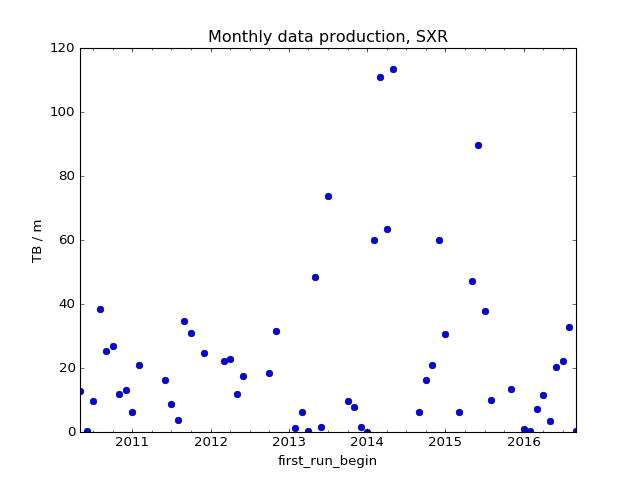

<IPython.core.display.Javascript object>


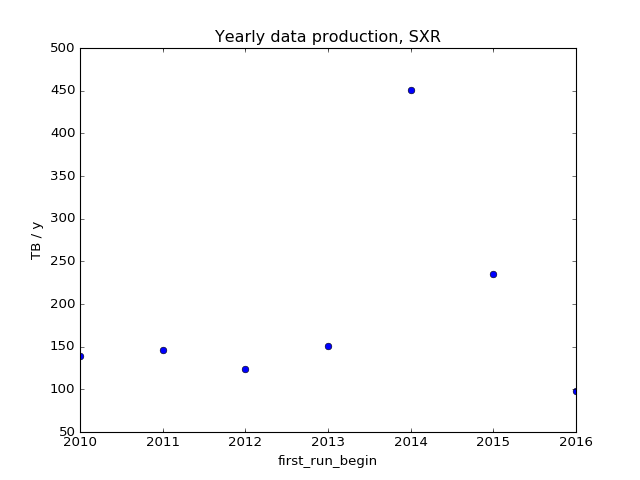

<IPython.core.display.Javascript object>


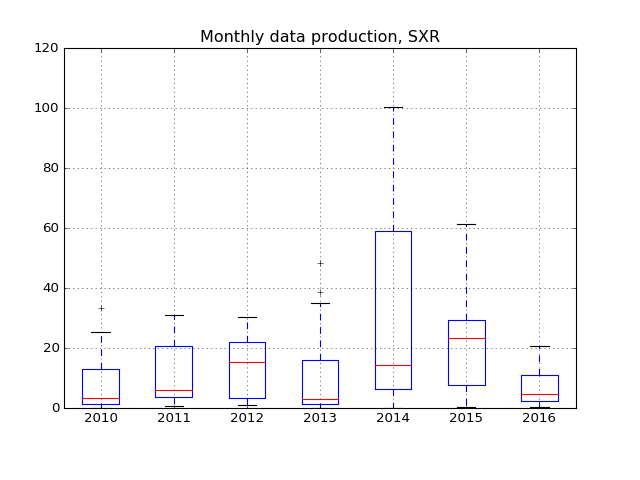

<IPython.core.display.Javascript object>


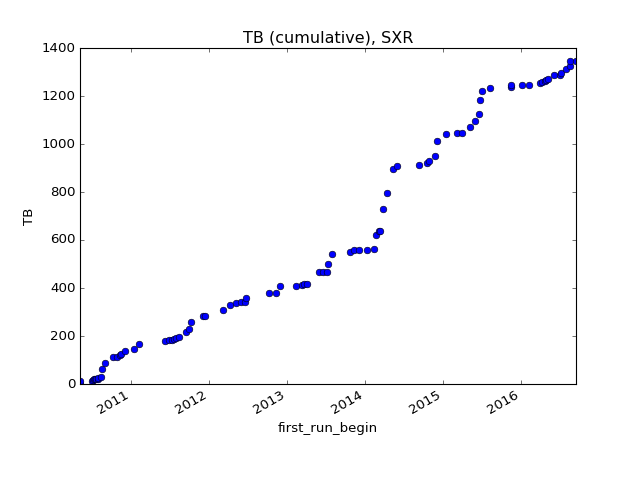

In [178]:
plt.figure()
d = df_s.size_tb_xtc.resample('M').sum()
d.plot(style='o', title="Monthly data production, %s" % iname)
plt.ylabel("TB / m")

plt.figure()
d = df_s.size_tb_xtc.resample('A').sum()
d.plot(style="o", title="Yearly data production, %s" % iname)
plt.ylabel("TB / y")

a = df_s.boxplot(column="size_tb_xtc", by=df_s.index.year)
a.set_xlabel("")
a.set_title("Monthly data production, %s" % iname)
a.get_figure().suptitle("")

plt.figure()
d = df_s.size_tb_xtc.cumsum()
d.plot(style='o', title="TB (cumulative), %s" % iname )
plt.ylabel("TB")

The spike is mostly due to single experiments, as it is quite unique:

In [173]:
df_s[(df_s.size_tb_xtc > 90)]

,exper_id,exper_name,files,files_disk,first_run_begin,instr_name,last_run_begin,runs,size_tb,size_tb_disk,files_xtc,files_hdf5,files_disk_xtc,files_disk_hdf5,size_tb_disk_xtc,size_tb_disk_hdf5,size_tb_xtc,size_tb_hdf5
first_run_begin,,,,,,,,,,,,,,,,,,
2014-03-25,415,sxrd5814,"{'hdf5': 2, 'xtc': 1705}","{'hdf5': 0, 'xtc': 164}",2014-03-25,SXR,2014-03-31,179,"{'hdf5': 0.7, 'xtc': 95.0}","{'hdf5': 0.0, 'xtc': 10.7}",1705,2,164,0,10.7,0.0,95.0,0.7
2014-05-09,429,sxrd5114,"{'hdf5': 0, 'xtc': 1543}","{'hdf5': 0, 'xtc': 0}",2014-05-09,SXR,2014-05-15,129,"{'hdf5': 0.0, 'xtc': 100.4}","{'hdf5': 0.0, 'xtc': 0.0}",1543,0,0,0,0.0,0.0,100.4,0.0


from http://www-ssrl.slac.stanford.edu/lcls-resources/schedules

* LD51: Visualizing Excited State Proton Transfer with Resonant Inelastic Xray Scattering
* LD58: Capturing the Ultrafast Generation of Magnetic Order on the Nanoscale in a Laser-driven First Order Phase Transition